In [187]:
# Connect to server
#import pyodbc
#from dotenv import dotenv_values

# Datetime
from datetime import datetime

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns
import missingno as msno

# Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Statistical Analysis
import scipy.stats as stats
from statsmodels.stats.weightstats import ttest_ind
import statsmodels.api as sm
from pmdarima.arima import CHTest, nsdiffs
from pmdarima.arima import auto_arima
#from arch.unitroot import ADF, KPSS
from statsmodels.stats.diagnostic import acorr_ljungbox
#import phik
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller

# Machine Learning Modeling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
#import xgboost as xgb
from sklearn.metrics import mean_squared_error
import joblib
from sklearn.pipeline import Pipeline

import os

import random

import warnings
import time

# ignore warnings
warnings.filterwarnings('ignore')

from pathlib import Path, PureWindowsPath

In [188]:
#! pip install missingno
#! pip install pmdarima

### Import data

In [189]:
path_cwd = Path(PureWindowsPath(os.path.dirname(os.getcwd())))
path_cwd
path = path_cwd / 'data/processed/'

In [224]:
train_data = pd.read_pickle(path / 'df_train.pkl')
val_data = pd.read_pickle(path / 'df_val.pkl')
test_data = pd.read_pickle(path / 'df_test.pkl')

In [225]:
train_data.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'cluster',
       'familycluster', 'day_of_week', 'month', 'year', 'oil_price',
       'holiday_Carnaval', 'holiday_Dia de la Madre',
       'holiday_Dia del Trabajo', 'holiday_Fundacion de Quito',
       'holiday_Independencia de Cuenca',
       'holiday_Mundial de futbol Brasil: Ecuador-Suiza', 'holiday_Navidad-1',
       'holiday_Navidad-2', 'holiday_Navidad-3', 'holiday_Navidad-4',
       'holiday_Primer dia del ano', 'holiday_Terremoto Manabi+1',
       'holiday_Terremoto Manabi+2', 'holiday_Terremoto Manabi+3',
       'holiday_Terremoto Manabi+4', 'holiday_Terremoto Manabi+5',
       'holiday_Traslado Primer dia del ano'],
      dtype='object')

In [226]:
train_data['familycluster'].unique()

array([ 6,  2, 20,  0, 15, 16,  4,  9,  3, 13, 12, 14,  8, 19, 18, 11,  5,
        7, 10,  1, 17], dtype=int64)

In [227]:
val_data['date']

0        2016-04-26
1        2016-04-26
2        2016-04-26
3        2016-04-26
4        2016-04-26
            ...    
276564   2016-10-03
276565   2016-10-03
276566   2016-10-03
276567   2016-10-03
276568   2016-10-03
Name: date, Length: 276569, dtype: datetime64[ns]

## Modeling ##

In [228]:
# Updated plot_predictions to work with dataframes where the date is not already aggregated
# This simply aggregates the dates inside the function
def plot_predictions(date, y_test, y_pred, forecast_label, title):
    """
    Plot the actual and predicted time series data.

    Parameters:
    date (array-like): Date or time index.
    y_test (array-like): Actual values.
    y_pred (array-like): Predicted values.
    forecast_label (str): Label for the forecasted data.
    title (str): Title for the plot.
    """
    # Combine the data into a DataFrame
    data = pd.DataFrame({'Date': date, 'Actual': y_test, 'Predicted': y_pred})
    
    # Aggregate the data by date, taking the mean of the values for each day
    data = data.groupby('Date').mean().reset_index()
    
    # Set the custom color palette
    custom_palette = sns.color_palette("husl", 2)
    sns.set_palette(custom_palette)
    
    # Create a figure with specified dimensions
    plt.figure(figsize=(10, 6))

    # Plot the actual data in green
    sns.lineplot(data=data, x='Date', y='Actual', label='Actual', color=custom_palette[0])

    # Plot the predicted data in blue with the specified label
    sns.lineplot(data=data, x='Date', y='Predicted', label=forecast_label, color=custom_palette[1])

    # Add a legend to the plot
    plt.legend()

    # Set the title of the plot
    plt.title(title)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Display the plot
    plt.show()

In [229]:
# Define a function to compute the evaluations metrics after the forecast
def evaluate_forecast(y_test, forecast):
    """
    Compute MSE, RMSE, and RMSLE for a forecast.

    Parameters:
    y_test (array-like): Actual values.
    forecast (array-like): Predicted values.

    Returns:
    dict: Dictionary containing MSE, RMSE, and RMSLE.
    """
    def rmsle(predicted, actual):
        return np.sqrt(np.mean(np.square(np.log1p(predicted) - np.log1p(actual))))

    # Compute Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, forecast)
    
    # Compute Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    
    # Compute Root Mean Squared Logarithmic Error (RMSLE)
    rmsle_value = rmsle(forecast, y_test)
    
    # Return the evaluation metrics as a dictionary
    metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'RMSLE': rmsle_value
    }
    
    return metrics

In [230]:
# Exogenous variables to help predict sales
#ex_variables = ['onpromotion', 'day_of_week', 'lag_1', 'rolling_mean']
ex_variables = ['onpromotion', 'day_of_week']

## OLS ##

### create dummy variables ###

In [231]:
train_data.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'cluster',
       'familycluster', 'day_of_week', 'month', 'year', 'oil_price',
       'holiday_Carnaval', 'holiday_Dia de la Madre',
       'holiday_Dia del Trabajo', 'holiday_Fundacion de Quito',
       'holiday_Independencia de Cuenca',
       'holiday_Mundial de futbol Brasil: Ecuador-Suiza', 'holiday_Navidad-1',
       'holiday_Navidad-2', 'holiday_Navidad-3', 'holiday_Navidad-4',
       'holiday_Primer dia del ano', 'holiday_Terremoto Manabi+1',
       'holiday_Terremoto Manabi+2', 'holiday_Terremoto Manabi+3',
       'holiday_Terremoto Manabi+4', 'holiday_Terremoto Manabi+5',
       'holiday_Traslado Primer dia del ano'],
      dtype='object')

In [232]:
def create_dummy_fam_cluster(df):
    df2 = df.drop(columns=['store_nbr','family','id','date'])
    df2  = pd.get_dummies(df2, columns=['familycluster','cluster']) 
    return df2

def create_dummy(df):
    df2 = df.drop(columns=['store_nbr','familycluster','id','date'])
    df2  = pd.get_dummies(df2, columns=['family','cluster']) 
    return df2


In [233]:
df_train_ols = create_dummy(train_data)
df_val_ols = create_dummy(val_data)
df_test_ols = create_dummy(test_data)

### scale df ###

In [234]:
def scale_df(df, colums_to_scale):
    # Introduce MinMaxScaler for primary FE 
    scaler = MinMaxScaler()
    # Apply
    df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
    return df

In [235]:
columns_to_scale =  list(df_train_ols.columns)
columns_to_scale.remove('sales')
columns_to_scale.remove('onpromotion')
columns_to_scale.remove('day_of_week')
columns_to_scale.remove('month')
columns_to_scale.remove('year')
columns_to_scale.remove('oil_price')


In [236]:
df_train_ols = scale_df(df_train_ols, columns_to_scale)
df_val_ols = scale_df(df_val_ols, columns_to_scale)
df_test_ols = scale_df(df_test_ols, columns_to_scale)

### add constant ###

In [237]:
X_ols = df_train_ols.drop(columns=['sales'])
# add constant for linear regression

X_ols.insert(0, 'const',1)


#X_ols = sm.add_constant(X_ols)
y_ols = train_data['sales']
y_ols = df_train_ols['sales']

In [238]:
X_val_ols = df_val_ols.drop(columns=['sales'])
# add constant for linear regression
X_val_ols.insert(0, 'const',1)
y_val_ols = df_val_ols['sales']

In [239]:
X_test_ols = df_test_ols.drop(columns=['sales'])
# add constant for linear regression
X_test_ols.insert(0, 'const',1)
y_test_ols = df_test_ols['sales']

In [240]:
print(X_val_ols.shape,y_val_ols.shape, X_test_ols.shape, y_test_ols.shape)

(276569, 73) (276569,) (553141, 73) (553141,)


In [241]:
model_OLS = sm.OLS(y_ols,X_ols).fit()
model_summary = model_OLS.summary()

In [242]:
#model_summary

In [243]:
print(X_val_ols.shape, X_ols.shape)

(276569, 73) (1935987, 73)


In [244]:
# validation metrics
val_ols_predictions = model_OLS.predict(X_val_ols)
ols_metrics = evaluate_forecast(y_val_ols, val_ols_predictions)

ols_metrics

{'MSE': 637028.8208558713,
 'RMSE': 798.1408527671487,
 'RMSLE': 2.2725945479839083}

In [245]:
# test metrics
test_ols_predictions = model_OLS.predict(X_test_ols)
ols_metrics_test = evaluate_forecast(y_test_ols, test_ols_predictions)

ols_metrics_test

{'MSE': 745707.7296348342,
 'RMSE': 863.5437045308328,
 'RMSLE': 2.4677592937172315}

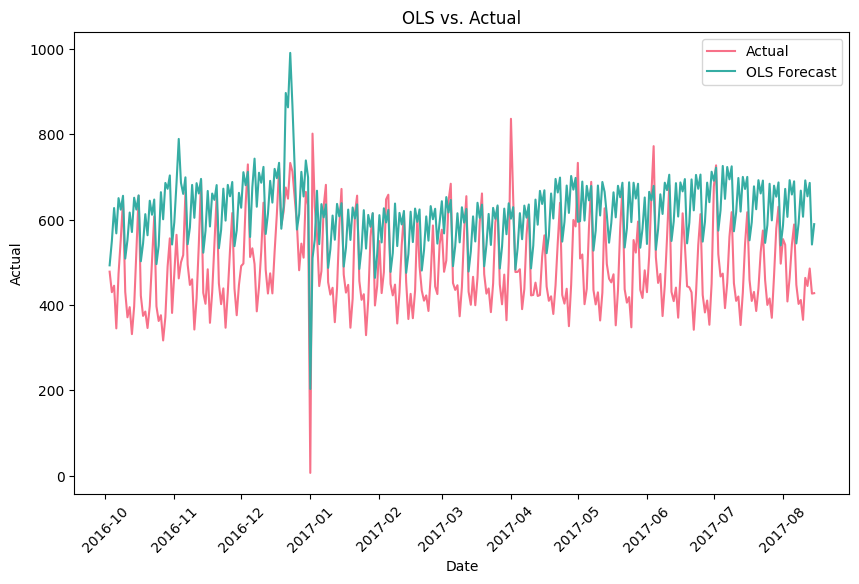

In [246]:
plot_predictions(test_data['date'],y_test_ols, test_ols_predictions, 'OLS Forecast', 'OLS vs. Actual') #need toconvert series to dfs

## OLS with family cluster ##

In [247]:
df_train_ols = create_dummy_fam_cluster(train_data)
df_val_ols = create_dummy_fam_cluster(val_data)
df_test_ols = create_dummy_fam_cluster(test_data)

In [248]:
columns_to_scale =  list(df_train_ols.columns)
columns_to_scale.remove('sales')
columns_to_scale.remove('onpromotion')
columns_to_scale.remove('day_of_week')
columns_to_scale.remove('month')
columns_to_scale.remove('year')
columns_to_scale.remove('oil_price')


In [249]:
df_train_ols = scale_df(df_train_ols, columns_to_scale)
df_val_ols = scale_df(df_val_ols, columns_to_scale)
df_test_ols = scale_df(df_test_ols, columns_to_scale)

In [250]:
X_ols = df_train_ols.drop(columns=['sales'])
# add constant for linear regression

X_ols.insert(0, 'const',1)


#X_ols = sm.add_constant(X_ols)
y_ols = train_data['sales']
y_ols = df_train_ols['sales']

In [251]:
X_val_ols = df_val_ols.drop(columns=['sales'])
# add constant for linear regression
X_val_ols.insert(0, 'const',1)
y_val_ols = df_val_ols['sales']

In [252]:
X_test_ols = df_test_ols.drop(columns=['sales'])
# add constant for linear regression
X_test_ols.insert(0, 'const',1)
y_test_ols = df_test_ols['sales']

In [253]:
model_OLS = sm.OLS(y_ols,X_ols).fit()
model_summary = model_OLS.summary()

In [254]:
# validation metrics
val_ols_predictions = model_OLS.predict(X_val_ols)
ols_metrics = evaluate_forecast(y_val_ols, val_ols_predictions)

ols_metrics

{'MSE': 1046472.4465467597,
 'RMSE': 1022.9723586425782,
 'RMSLE': 2.781766685975577}

In [255]:
# test metrics
test_ols_predictions = model_OLS.predict(X_test_ols)
ols_metrics_test = evaluate_forecast(y_test_ols, test_ols_predictions)

ols_metrics_test

{'MSE': 1156891.5104809164,
 'RMSE': 1075.588913331165,
 'RMSLE': 2.8356245755285134}

## SARIMA ##

In [222]:
train_data_sarima = train_data_s[train_data_s['date']=='2015-09-01']
train_data_sarima = train_data_s.set_index('date')
val_data_sarima = val_data_s.set_index('date')

NameError: name 'train_data_s' is not defined

In [ ]:
train_data_sarima_exog = train_data_sarima[['familycluster','cluster']]
y_train_sarima_endog = train_data_sarima['sales']

val_data_sarima_exog = val_data_sarima[['familycluster','cluster']]
y_val_sarima_endog = val_data_sarima['sales']

In [ ]:
val_data_sarima_exog

In [ ]:
# Group by date to sum sales

ts = train_data_sarima.groupby(train_data_sarima['date'])['sales'].sum()
#ts = train_data_sarima.groupby(train_data_sarima.index)['sales'].sum()
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(12,6))

# Plot ACF
sm.graphics.tsa.plot_acf(ts, lags=40, ax=ax1)
ax1.set_title('ACF')

# Plot PACF
sm.graphics.tsa.plot_pacf(ts, lags=40, ax=ax2)
ax2.set_title('PACF')

plt.tight_layout(pad=2.0)

plt.show()

# runs into memory error when trying to run. will have to manually find hyperparams
start_time = time.time()
sarima_model = auto_arima(train_data_sarima['sales']
                          #, exogenous=train_data_s[['familycluster', 'onpromotion','holiday']]
                          #, exogenous=train_data_s[['familycluster']]
                          , start_p=0 , max_p=3, start_P=0 , max_P=3 
                          , d=None , D=1 #not sure this is a good value for d
                          , start_q=0 , max_q= 3 , start_Q=0 , max_Q=3
                          , random=True, n_fits=2
                          , seasonal=True, m=12, random_state=21, trace=True )

end_time = time.time()
elapsed_time = end_time - start_time

# too slow to get results
def ad_fuller(timeseries):
    print ('Dickey-Fuller Test indicates:')
    df_test = adfuller(timeseries, regression='ct', autolag='AIC')
    output = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print(output)

print(ad_fuller(train_data_s['sales']))

In [ ]:
# Define the instance
model_sarima = sm.tsa.SARIMAX(endog=y_train_sarima_endog, exog=train_data_sarima_exog, order=(1,1,1), seasonal_order=(1,1,1,12))



In [ ]:
# Fit the model
results_sarima = model_sarima.fit()



In [ ]:
# Make predictions
forecast_sarima = results_sarima.predict(start=len(train_data_sarima), end=len(train_data_sarima) + len(val_data_sarima) - 1, dynamic=False)

In [ ]:
sarima_metrics = evaluate_forecast(y_val_sarima, forecast_sarima)

sarima_metrics